# QAOA method to solve for MIS Problem (R_b/a ~ 3)
### This notebook explores the effect of the QAOA and how it performs on increasingly more complex MIS graphs and tunes parameters and pulse sequences!

First let's test how it works with the graph in the Handout with R_b/a ~ 3:

In [4]:
using Bloqade
using BloqadeMIS
using Random
using Optim
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

In [1]:
atom1 = AtomList([(0.0, 0.0), (0.0, 4.5), (0.0, 9.0), (0.0, 13.5), (0.0, 18.0), (4.5, 0.0),  
     (4.5, 13.5), (4.5, 18.0), (9.0, 0.0), (9.0, 9.0), (9.0, 13.5), (9.0, 18.0),
    (13.5, 0.0), (13.5, 4.5), (13.5, 9.0), (13.5, 13.5), (13.5, 18.0), (18.0, 0.0),
    (18.0, 13.5), (18.0, 18.0)]);

UndefVarError: UndefVarError: `AtomList` not defined

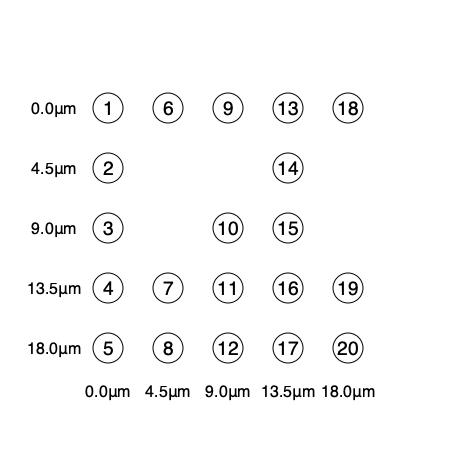

In [27]:
atom1

In [28]:
a = 4.5
Rb = sqrt(3*sqrt(10))*a

13.860316297084605

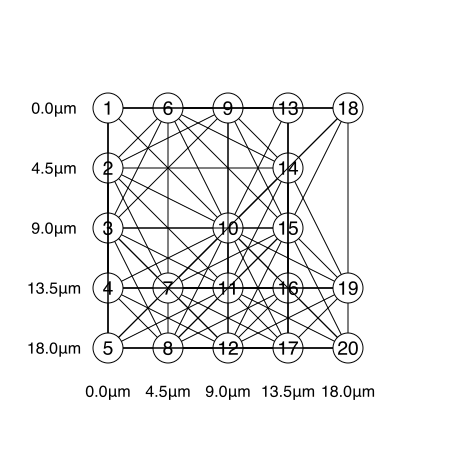

In [29]:
Bloqade.plot(atom1, blockade_radius = Rb)

The pulse sequence takes advantage of the Heisenberg picture, performing rotation of operators and this works with keep \Omega as constant as possible and \Delta 0 for as long as possible

4.8[0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1][0.0, 0.5, 0.6, 1.1, 1.2, 1.7, 1.8, 2.3, 2.4000000000000004, 2.9000000000000004, 3.0000000000000004, 3.5000000000000004, 3.6000000000000005, 4.1000000000000005, 4.200000000000001, 4.700000000000001, 4.800000000000001]

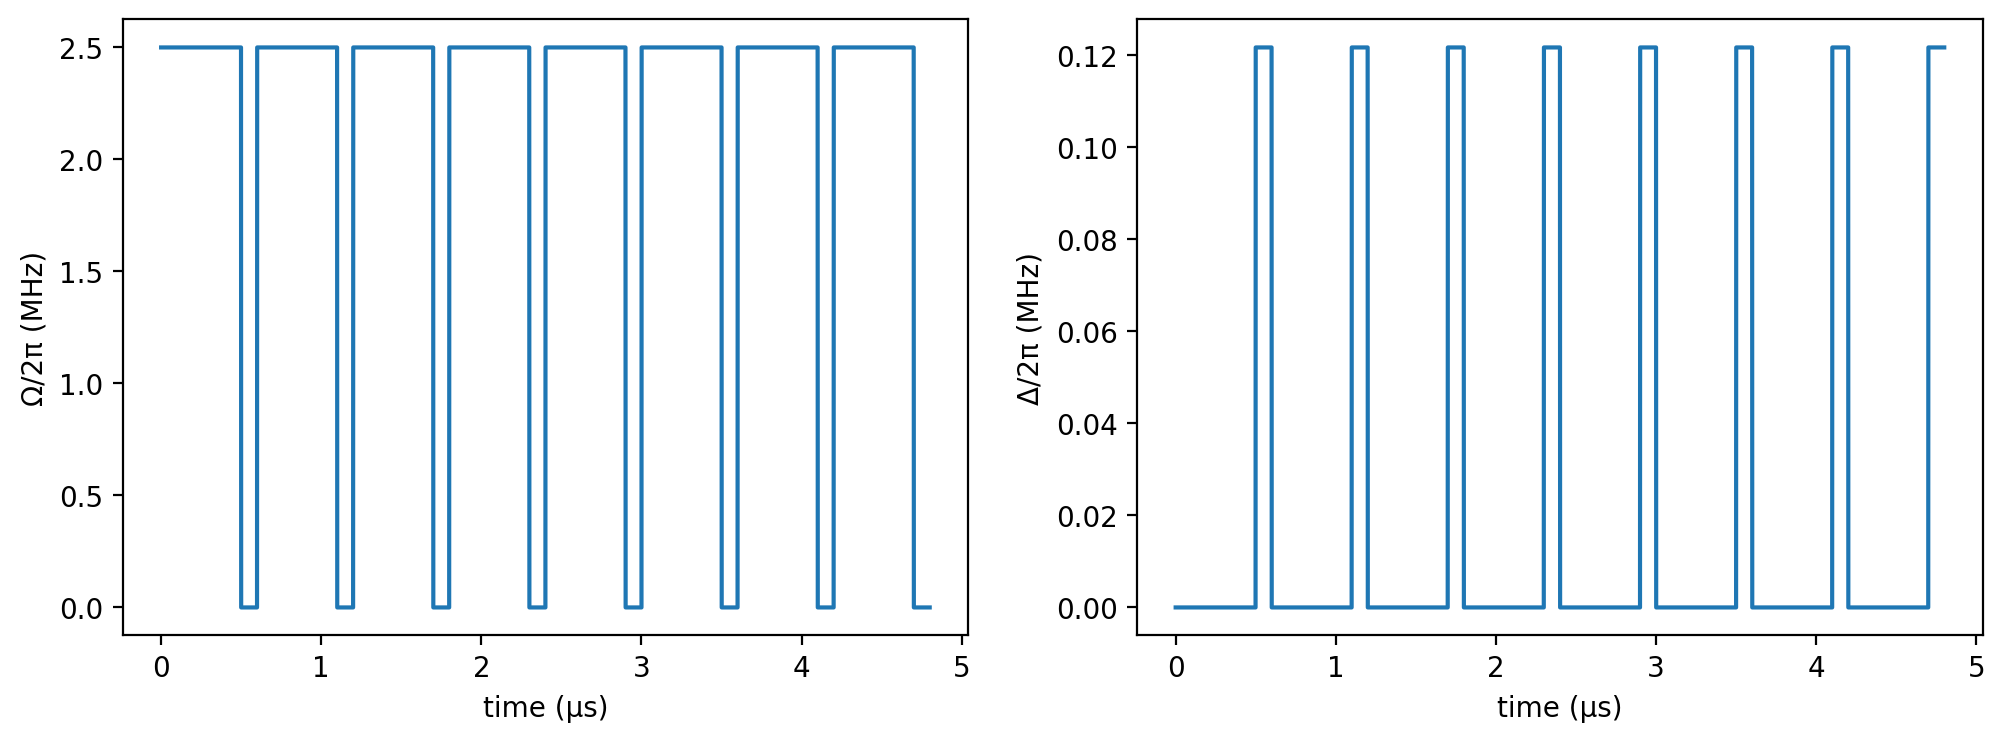

In [65]:
#Total evolution time
T_max = 4.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6
Δ_end = Δ_max

# durations = fill(0.5, 8)
durations = [0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1]
print(sum(durations))
print(durations)
clocks = [0, cumsum(durations)...]
print(clocks)
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 8))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 8))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [66]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 2π*2.5
    Δ_end = (2π * 862690) / 11.65509028850108^6
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 11.65509028850108)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [67]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atom1, x0)
rydberg_density

-2.3125762297658214

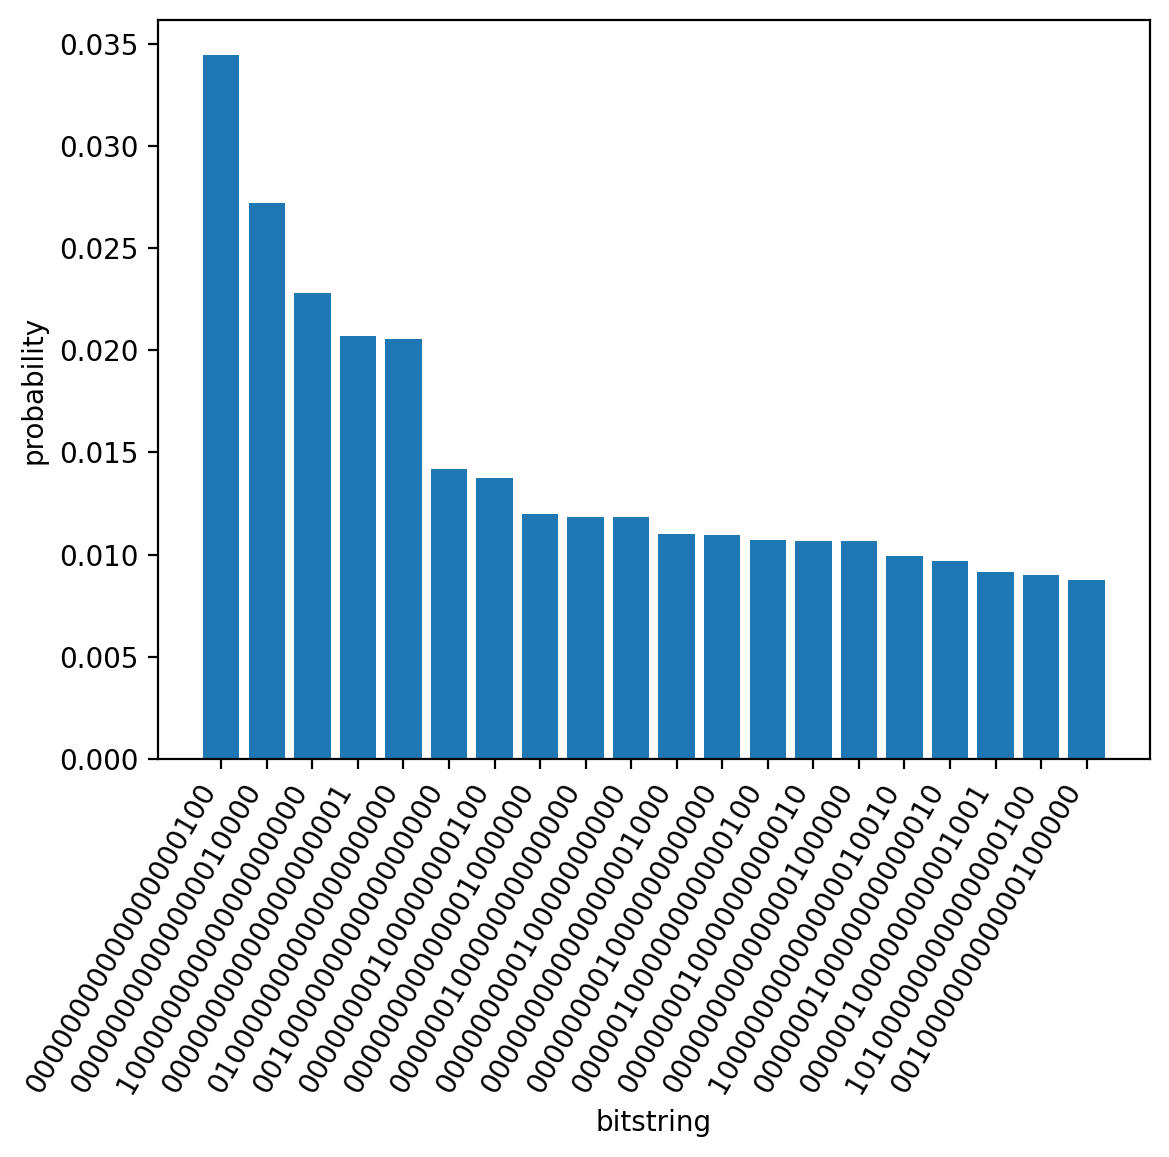

In [68]:
bitstring_hist(reg1; nlargest = 20)

In [69]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atom1, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atom1, optresult.minimizer)
rydberg_density_final

-2.8474637225689765

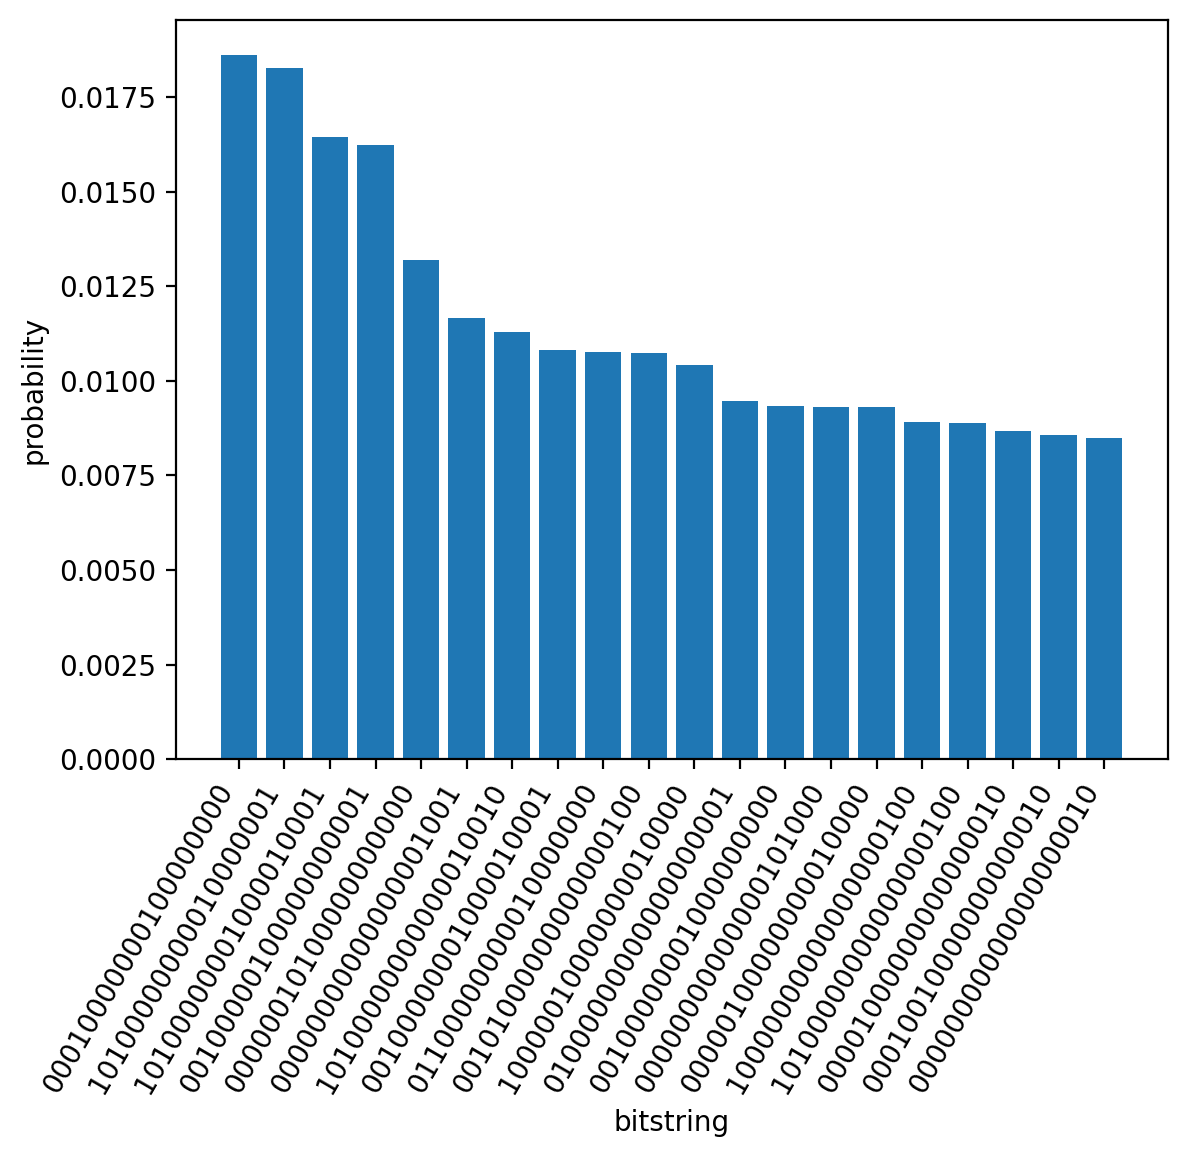

In [70]:
bitstring_hist(reg1_final; nlargest = 20)

We need to Post-Process these results since not all of them are independent sets!

In [80]:
probs(reg1_final)
best_bit_strings = most_probable(reg1_final, 10)


10-element Vector{DitStr{2, 20, Int64}}:
 00010000000100000000 ₍₂₎
 10100000000010000001 ₍₂₎
 10100000001000010001 ₍₂₎
 00100000100000000001 ₍₂₎
 00000010100000000000 ₍₂₎
 00000000000000001001 ₍₂₎
 10100000000000010010 ₍₂₎
 00100000001000010001 ₍₂₎
 01100000000010000000 ₍₂₎
 00101000000000000100 ₍₂₎

In [154]:
function count_ones(n)
    counter = 0
    for bit in n
        if bit == 1
            counter = counter + 1
        end
    end
    # return count(c -> c == '1', string(n))
    return counter
end

count_ones (generic function with 2 methods)

In [155]:
new_bit_strings = zeros(10);
graph = BloqadeMIS.unit_disk_graph(atom1, Rb)

{20, 111} undirected simple Int64 graph

In [169]:
# print(graph)
# gplot(graph, nodelabel=1:nv(graph))
best_bit_strings[2]

10100000000010000001 ₍₂₎

In [163]:
max = 0
new_bit_strings = Dict()
for i in 1:10
    # config = to_independent_set(best_bit_strings[i], graph)
    # config = add_random_vertices(config, graph, ntrials)
    # new_bit_strings[i] = config
    # config = ""
    # for  bit in best_bit_strings[i]
    #     config = config * string(bit)  # Or any value you wish to set
    # end
    # num = parse(Int64, config)
    # print(typeof(num))
    # new_bit_strings[i] = BloqadeMIS.mis_postprocessing(num, graph)
    if is_independent_set(best_bit_strings[i], graph)
        print(i)
        n = count_ones(best_bit_strings[i])
        new_bit_strings[n] = best_bit_strings[i]
        if max < n
            max = n
        end
    end
end

14510

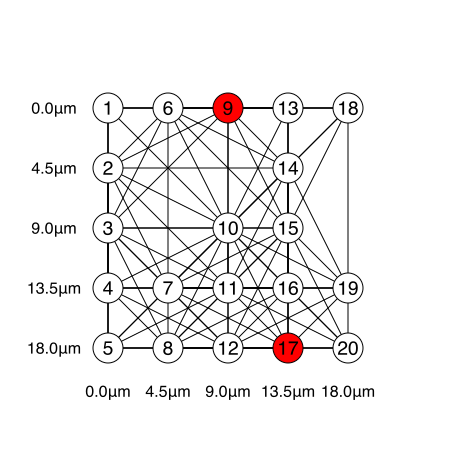

In [170]:
# best_bit_strings = most_probable(reg1_final, 4)

Bloqade.plot(atom1, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

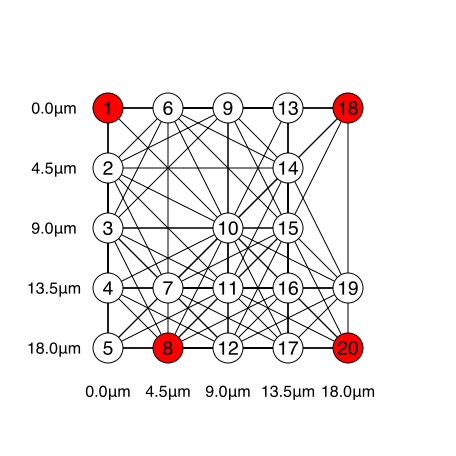

In [171]:
Bloqade.plot(atom1, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

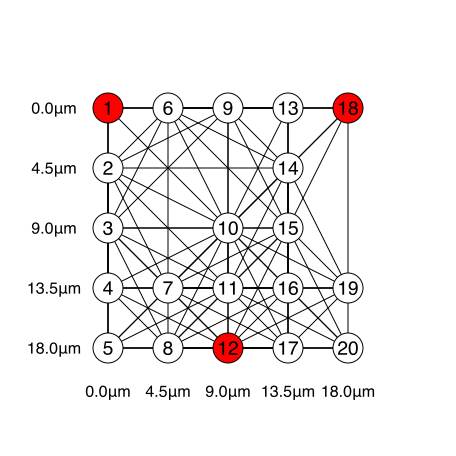

In [77]:
Bloqade.plot(atom1, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[4]])

### Look's like after QAOA we get a pretty reliable chance of landing the MIS in the top 3 results
## Let's try a more complex graph!

In [2]:
Random.seed!(2)
a=4.5
atom2 = generate_sites(SquareLattice(), 6, 6; scale = a) |> random_dropout(0.4)

UndefVarError: UndefVarError: `Random` not defined

In [173]:
Rb = sqrt(3*sqrt(10))*a

13.860316297084605

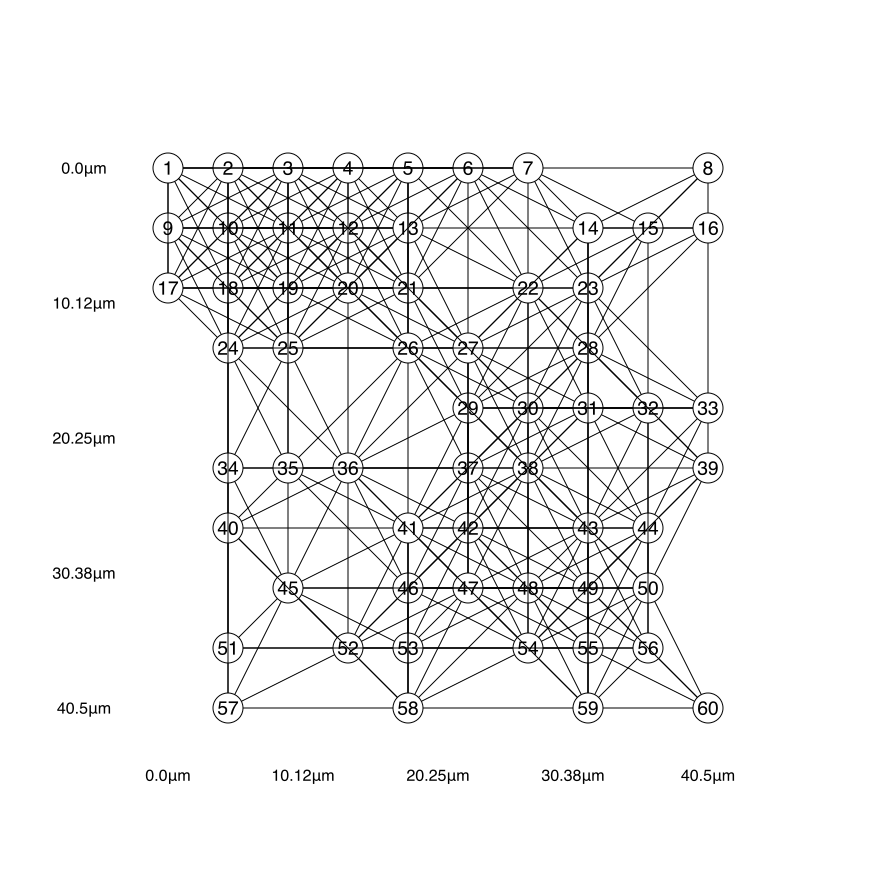

In [174]:
Bloqade.plot(atom2, blockade_radius = Rb)

4.8[0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1][0.0, 0.5, 0.6, 1.1, 1.2, 1.7, 1.8, 2.3, 2.4000000000000004, 2.9000000000000004, 3.0000000000000004, 3.5000000000000004, 3.6000000000000005, 4.1000000000000005, 4.200000000000001, 4.700000000000001, 4.800000000000001]

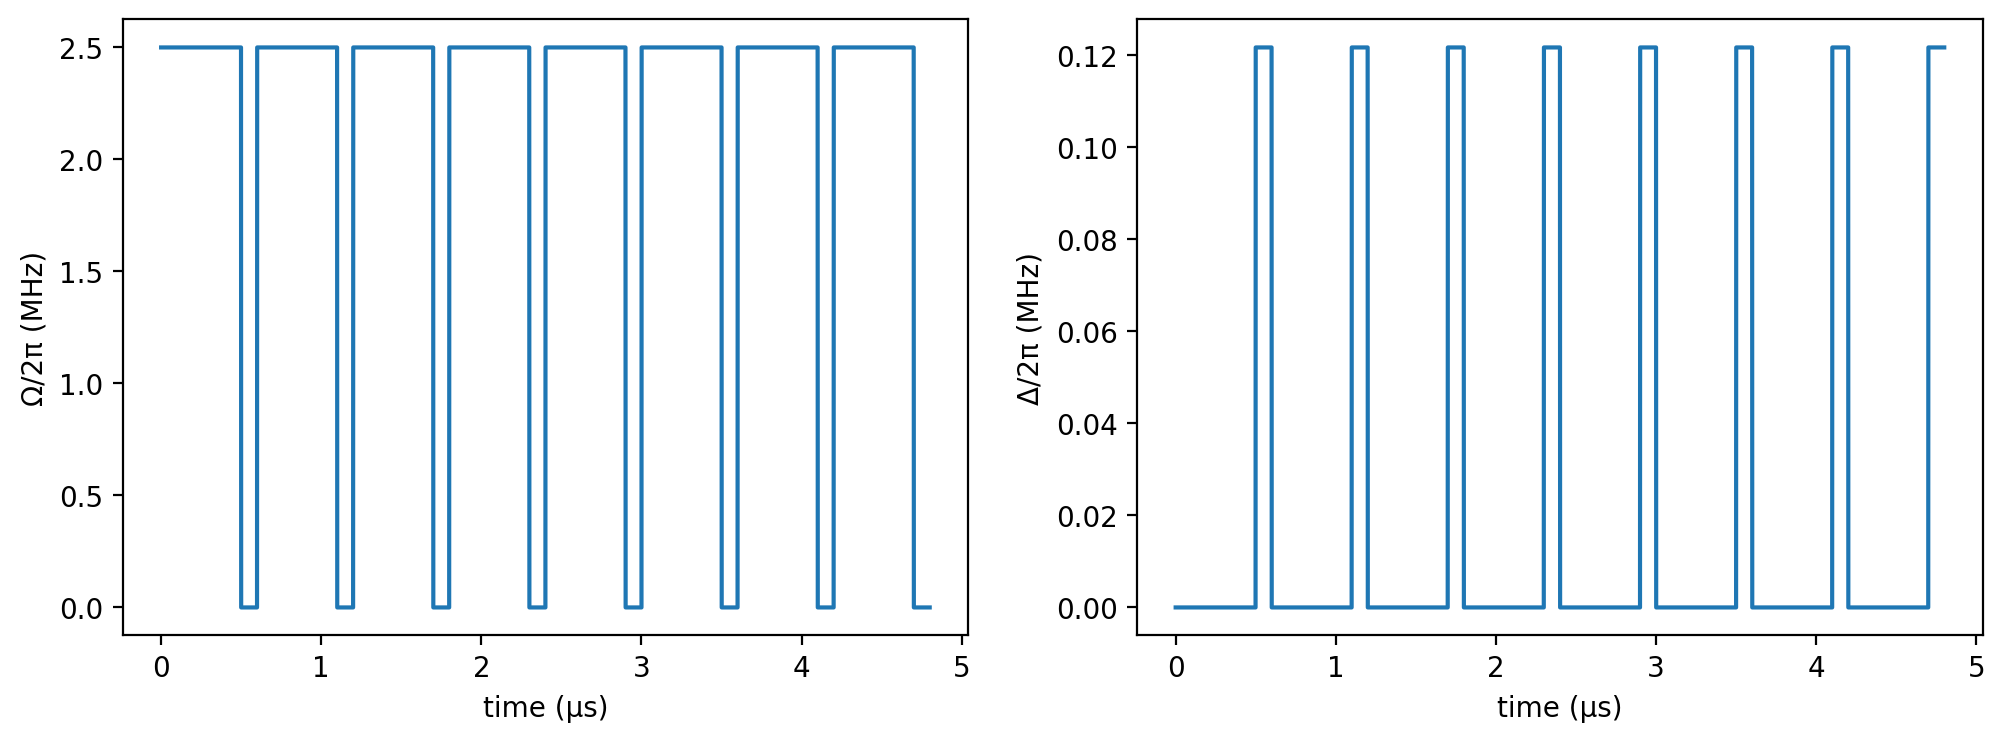

In [175]:
#Total evolution time
T_max = 4.0

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6
Δ_end = Δ_max

# durations = fill(0.5, 8)
durations = [0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1, 0.5, 0.1]
print(sum(durations))
print(durations)
clocks = [0, cumsum(durations)...]
print(clocks)
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 8))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 8))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [1]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atom1, x0)
rydberg_density

UndefVarError: UndefVarError: `durations` not defined

In [ ]:
bitstring_hist(reg1; nlargest = 20)

In [ ]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atom2, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atom1, optresult.minimizer)
rydberg_density_final

In [ ]:
bitstring_hist(reg1_final; nlargest = 20)

In [ ]:
probs(reg1_final)
best_bit_strings = most_probable(reg1_final, 10)

In [ ]:
Bloqade.plot(atom1, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])